## Non-variational fixed-depth Hamiltonian simulation

Here we reproduce the the main demonstration example of "Fixed-depth Hamiltonian simulation via Cartan decomposition"
with our recursive KAK decomposition tool.

In [16]:
from functools import partial
from itertools import combinations, product
import numpy as np
np.random.seed(2415)
from scipy.linalg import expm
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from tqdm.notebook import tqdm

import jax
jax.config.update("jax_enable_x64", True)

import pennylane as qml
from pennylane import X, Y, Z, I
from pennylane.devices.default_qubit import stopping_condition as sc_def

from kak_tools import map_simple_to_irrep, map_irrep_to_matrices, identify_algebra, split_pauli_algebra, bdi, lie_closure_pauli_words, recursive_bdi, map_recursive_decomp_to_reducible, map_matrix_to_reducible

We begin by defining the Pauli words in the Hamiltonian 

$
H = \sum_{j=1}^{n-1} \alpha_j X_j X_{j+1} + \beta_j Y_j Y_{j+1} + \sum_{j=1}^n \gamma_j Z_j
$

and computing their Lie closure. We obtain a reducible representation of $\mathfrak{so}(2n)$ on $\mathbb{C}^{2^n}$.

In [2]:
n = 10 # Number of qubits

# Hamiltonian terms
couplings = [X(w) @ X(w+1) for w in range(n-1)] + [Y(w) @ Y(w+1) for w in range(n-1)]
Zs = [Z(w) for w in range(n)]
generators = couplings + Zs
# Map from general qml.operation.Operator instances to qml.pauli.PauliWord instances
generators = [next(iter(op.pauli_rep)) for op in generators]

# Compute Hamiltonian Lie algebra
algebra = lie_closure_pauli_words(generators, verbose=False)

# Compare algebra size to expected size of so(2n)
n_so = 2 * n # The "n" in so(n)
so_dim = (n_so**2-n_so) // 2

print(f"Hamiltonian algebra on {n} qubits with size {len(algebra)}; expected size is {so_dim}")

Hamiltonian algebra on 10 qubits with size 190; expected size is 190


Next, we map this irreducible representation to an irreducible representation on $\mathbb{R}^{2n}$,
by creating a `mapping` of each Pauli word to a basis element $F_{ij} = E_{ij} - E_{ji}$, where $E_{ij}$ is the real $2n \times 2n$ matrix with a $1$
at position $(i, j)$ and zeros else (we will use zero-based indexing). This mapping does not contain the signs required to make it an algebra homomorphism,
but we compute them in a separate lookup table `signs`.

We have one more requirement for this mapping, though:
The Pauli words from $H$ stored in `generators` are horizontal with respect to an involution on the reducible representation.
In order to use the KAK theorem for the mapping of $H$, we need to make sure that these generators are mapped to basis elements that
are horizontal with respect to the involution on the irreducible representation of the same type.
We will use an involution of type BDI and in the irreducible representation, we choose the canonical form of the involution

$
\theta(x) = I_{n, n} x I_{n, n} \text{ with } I_{n, n} = \operatorname{diag}(\underset{\times n}{\underbrace{1, \cdots, 1}}, \underset{\times n}{\underbrace{-1, \cdots, -1}}).
$

The basis elements $F_{ij}$ above are eigenstates of this involution, and the horizontal (eigenvalue $-1$) elements are those with $i<n$ and $j\geq n$:

$$
\theta(F_{ij}) 
= \delta_{k\ell} (\lambda(k<n) - \lambda(k>=n)) (E_{ij} - E_{ji})_{\ell m} \delta_{mp} (\lambda(m<n) - \lambda(m>=n))
= (-1)^{i>n} (-1)^{j>n} F_{ij} 
$$

We therefore make sure to map the Hamiltonian Pauli words to such elements with $i<n$ and $j\geq n$, by passing `generators` to `map_simple_to_irrep`
and the involution type `"BDI"`.

In [3]:
mapping, signs = map_simple_to_irrep(algebra, horizontal_ops=generators, n=n_so, invol_type="BDI", invol_kwargs={"p": n_so//2, "q": n_so//2})

This mapping can now be used to create dense matrices in the irreducible representation:

In [4]:
matrix_map = map_irrep_to_matrices(mapping, signs, n_so, invol_type="BDI")

Now we can map individual Pauli operators to basis elements $F_{ij}$ in a homomorphic manner:

In [5]:
op1, op2 = algebra[0], algebra[n]
# Compute operator commutator, taking imaginary unit into account
ops_com = (qml.commutator(1j * op1, 1j * op2) / 1j).pauli_rep
# Make sure the commutator really is just a rescaled Pauli word
assert len(ops_com) == 1
# Extract Pauli word and scalar prefactor from operator commutator
[(ops_com_pw, ops_com_prefactor)] = ops_com.items()
# Map the Pauli word to irreducible basis element and include scalar prefactor
commutator_from_ops = matrix_map[ops_com_pw] * ops_com_prefactor

# Map the original operators to matrices directly and compute the matrix commutator
mat1, mat2 = matrix_map[op1], matrix_map[op2]
commutator_from_mats = mat1 @ mat2 - mat2 @ mat1

# Check whether the commutators agree
print(np.allclose(commutator_from_ops, commutator_from_mats))

True


Here we had to take into account that we store Pauli words in `algebra` but mathematically, the algebra consists of Pauli words multiplied
by the imaginary unit.

To take this one step further, we can compute the structure constants, which capture the essence of a Lie algebra without its representation,
in both representations. If our mapping is a homomorphism, it will maintain the structure constants.

In [6]:
# Only run this cell if the size of the structure constants tensor is manageable.
if n <= 10:
    from pennylane.labs.dla import structure_constants_dense
    
    # Compute structure constants for dense, low-dimensional irreducible representation
    # Convention: supply Hermitian instead of skew-Hermitian operators to structure_constants_dense
    adj_dense = structure_constants_dense([matrix_map[op]/1j for op in algebra], is_orthonormal=False)
    # Compute structure constants for sparse reducible representation
    adj = qml.pauli.dla.structure_constants(algebra, pauli=True)
    # Compare the two
    print(np.allclose(adj, adj_dense))

True


Next, we can sample some random coefficients for the Hamiltonian and then construct it in the reducible and irreducible representations.
For the former, we simply use `qml.dot` with the coefficients and the Pauli operators that generated the algebra.
For the former, we map the Hamiltonian generators to matrices and then combine those with the coefficients $\alpha$, $\beta$, $\gamma$.

Note that we renormalize the Hamiltonian by its trace norm, similar to the experiment performed in the model paper.

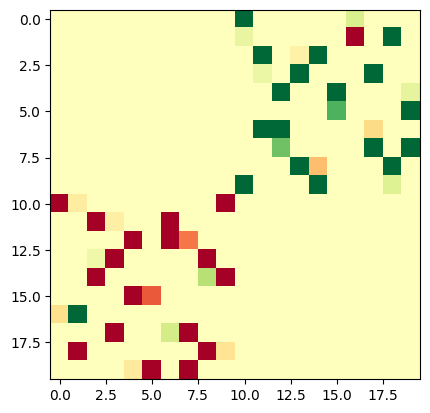

In [7]:
alphas = np.random.normal(0.6, 1., size=n-1)
betas = np.random.normal(0.3, 1.2, size=n-1)
alphas = np.ones(n-1)
betas = np.ones(n-1)
gammas = np.random.normal(0., 0.3, size=n)
coeffs = np.concatenate([alphas, betas, gammas])
coeffs /= np.linalg.norm(coeffs) # Normalization
H = qml.dot(coeffs, generators)
terms_irrep = np.stack([matrix_map[gen] for gen in generators])
H_irrep = np.tensordot(coeffs, terms_irrep, axes=[[0], [0]])

# Show pattern in H, which is BDI-horizontal
plt.imshow(H_irrep, cmap=plt.get_cmap("RdYlGn"))


Now we can move on to the KAK decomposition. For this we create an "exemplary" time evolution operator
$\exp(-i\epsilon H)$ with a small time scale of $\epsilon=10^{-3}$. This will ensure that we compile in a neighbourhood of the identity, where extracting
Pauli rotations from the irreducible representation works well.

Note that we will not have to include the imaginary unit here, because the implemented matrix `H_irrep` is an _algebra_ element, so that it already corresponds to $iH$.
As we are moving in the irreducible representation of $\mathfrak{so}(2n)$ here, `H_irrep` and the time evolution operator are just real $2n \times 2n$ matrices.

In [8]:
epsilon = 0.01
U = expm(epsilon * H_irrep)
print(U.shape, n_so)

(20, 20) 20


Then we apply our recursive BDI KAK decomposition to the time evolution operator, which will decompose the vertical operators in each step until we arrive at matrices of the form

$
\left(\begin{array}{cccc}
    \cos(a) & -\sin(a) & 0 & 0 \\
    \sin(a) & \cos(a) & 0 & 0 \\
    0 & 0 & \cos(b) & -\sin(b) \\
    0 & 0 & \sin(b) & \cos(b)
\end{array}\right),
$

corresponding to the operation $\exp(-i(aP_1+bP_2))$ where $P_1$ ($P_2$)is the Pauli word mapped to the basis element $F_{ij}$ matching the entry $-\sin(a)$ ($-\sin(b)$) in the matrix above. In particular, because those basis elements commute, $P_1$ and $P_2$ will, too, allowing us to pull the exponential apart into individual Pauli rotations, $\exp(-iaP_1)\exp(-ibP_2)$.

In [9]:
recursive_decomp = recursive_bdi(U, n_so)
num_iter = max(recursive_decomp.keys())

To arrive at a circuit that can be implemented in terms of Pauli rotation, we need to map back to the reducible representation.
This is done by the following function, which also takes the time scale $\epsilon=10^{-3}$ from above into account to arrive at a neutral 
decomposition of $\exp(iH)$ instead of $\exp(i\epsilon H)$

In [10]:
pauli_decomp = map_recursive_decomp_to_reducible(recursive_decomp, mapping, signs, "BDI", time=epsilon, assertions=False)

As we can see, `pauli_decomp` now contains tuples of a Pauli word, a coefficient, and a string that indicates whether the term stems from a
vertical space (`"k"`), an intermediate Cartan subalgebra (`"a"`), or the very first Cartan subalgebra (`"a0"`).
The distinction between `"k"` and `"a"` on one side and `"a0"` on the other will be important when we implement `exp(iHt)` for arbitrary times.

To make this data easier to use in a PennyLane circuit with `PauliRot`, let's rewrite it into tuples of 1) the coefficient, 2) a string summarizing
the non-identity Pauli operators of the Pauli word, 3) a `Wires` object to indicate where the Pauli word will act, and 4) the original type string.

In [11]:
paulirot_decomp = [(coeff, qml.pauli.pauli_word_to_string(pw), pw.wires, _type) for pw, coeff, _type in pauli_decomp]
print(f"We decomposed the time evolution into {len(paulirot_decomp)} Pauli rotations.")

We decomposed the time evolution into 190 Pauli rotations.


With this decomposition in our hands, we can construct a circuit implementing the time evolution operator. For
this we implement a function that translates our pre-processed Pauli rotation data into actual `PauliRot` gates.
It also takes into account that for a flexible-time evolution operator $\exp(-itH)$ with $t$ other than $\epsilon=10^{-3}$
from above, the central CSA element (as indicated by the string `"a0"`) needs to be rescaled by $t$.

In [12]:
def kak_time_evolution(time):
    # invert order because circuits and matrix products are written in opposite order
    for coeff, pauli_str, wires, _type in paulirot_decomp[::-1]:
        # Rescale the coefficient by the evolution time if the Pauli term is in the
        # central Cartan subalgebra
        if _type == "a0":
            coeff = coeff * time
        # Multiply by (-2) to undo the conventional builtin prefactor of -1/2 for PauliRot
        qml.PauliRot(-2 * coeff, pauli_word=pauli_str, wires=wires)

N = qml.dot([(1 - r) / 2 for r in range(1, n+1)], Zs) + sum([(r-1)/2 for r in range(1, n+1)])
N_sq = qml.simplify(N @ N)

if n < 28:
    dev_light = qml.device("lightning.qubit", wires=n) # Fast simulator
    dev_def = qml.device("default.qubit", wires=n) # Slower but supports large dense matrices

@qml.qnode(dev_light, grad_on_execution=False)
def kak_circuit(time):
    qml.X(0)
    kak_time_evolution(-time)
    return qml.expval(N_sq)

We will compare this circuit to an exact implementation of the time evolution and a Trotterized circuit. Let's set up those as well.
To allow us to count gates later on, we apply a decomposition transform to the Trotterized circuit that decomposes `Exp` operators
into more meaningful, concrete operations.

In [13]:
def stopping_condition(obj):
    return sc_def(obj) and not isinstance(obj, qml.ops.Exp)

@partial(qml.devices.preprocess.decompose, stopping_condition=stopping_condition)
@qml.qnode(dev_light, grad_on_execution=False)
def trotter_circuit(time, num_steps):
    qml.X(0)
    qml.exp(-1j * time * H, num_steps=num_steps)
    return qml.expval(N_sq)

@qml.qnode(dev_def, interface="jax", grad_on_execution=False)
def exact_circuit(time):
    qml.X(0)
    qml.exp(-1j * time * H)
    return qml.expval(N_sq)

In [14]:
if n < 28:
    times = np.linspace(0, 25, 50)
    all_num_steps = [2, 5, 10, 20]
    kak_out = jax.vmap(kak_circuit, in_axes=0)(times)
    assert np.allclose(np.abs(kak_out), kak_out)
    kak_out = np.abs(kak_out)

In [18]:
if n <= 10:
    if n<=6:
        exact_out = jax.vmap(exact_circuit, in_axes=0)(times)
    else:
        exact_circuit = jax.jit(exact_circuit)
        exact_out = np.array([exact_circuit(t) for t in tqdm(times)])

  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
if n < 28:
    trotter_out = [
        jax.vmap(partial(trotter_circuit, num_steps=ns), in_axes=0)(times)
        for ns in all_num_steps
    ]

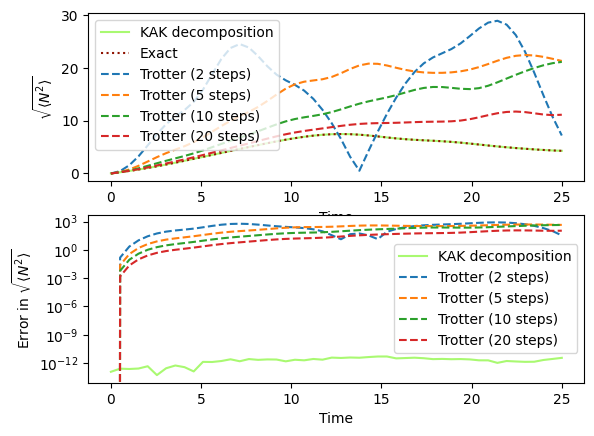

In [21]:
if n < 28:
    fig, axs = plt.subplots(2, 1)
    ax = axs[0]
    ax.plot(times, np.sqrt(kak_out), label="KAK decomposition", color="xkcd:spring green")
    if n <= 10:
        ax.plot(times, np.sqrt(exact_out), label="Exact", color="xkcd:brick red", ls=":")
    for ns, out in zip(all_num_steps, trotter_out):
        ax.plot(times, np.sqrt(out), label=f"Trotter ({ns} steps)", ls="--")
    ax.legend()
    ax.set_ylabel("$\sqrt{\\langle N^2\\rangle}$")
    ax.set_xlabel("Time")
    
    if n <= 10:
        ax = axs[1]
        ax.plot(times, np.abs(kak_out-exact_out), label="KAK decomposition", color="xkcd:spring green")
        for ns, out in zip(all_num_steps, trotter_out):
            ax.plot(times, np.abs(out-exact_out), label=f"Trotter ({ns} steps)", ls="--")
        ax.legend()
        ax.set_yscale("log")
        ax.set_ylabel("Error in $\sqrt{\\langle N^2\\rangle}$")
        ax.set_xlabel("Time");

In [ ]:
def get_paulirot_count(qnode):
    var_types = {"PauliRot", "IsingXX", "IsingYY", "RZ"}
    def wrapper(*args, **kwargs):
        specs = qml.specs(qnode)(*args, **kwargs)
        gate_count = specs['resources'].num_gates
        gate_types = specs['resources'].gate_types
        assert set(gate_types).issubset(var_types | {"PauliX"}), f"{gate_types}"
        assert gate_types["PauliX"] == 1
        var_gate_count = 0
        for t in var_types:
            var_gate_count += gate_types.get(t, 0) 
        assert gate_count == var_gate_count + 1
        return var_gate_count
    return wrapper

print(get_paulirot_count(kak_circuit)(times[-1]))
for ns in all_num_steps:
    print(get_paulirot_count(trotter_circuit)(times[-1], num_steps=ns))